In [70]:


from pathlib import Path
from utils.data_loader import load_crime_dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')




In [26]:
df_crime_path = Path('../datasets/chicago-crime-data.csv')


In [27]:
# Converting result into dataframe
df = pd.read_csv(df_crime_path)
df.head(4)

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location,:@computed_region_awaf_s7ux
0,13647521,JH488715,2024-10-27T00:00:00.000,045XX W WELLINGTON AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,20.0,14,1145677.0,1919561.0,2024,2024-11-03T15:42:31.000,41.935271,-87.740045,"{'latitude': '41.935270542', 'longitude': '-87...",7.0
1,13644362,JH484829,2024-10-27T00:00:00.000,015XX N LOCKWOOD AVE,0710,THEFT,THEFT FROM MOTOR VEHICLE,STREET,False,False,...,25.0,06,1140747.0,1909683.0,2024,2024-11-03T15:42:31.000,41.908256,-87.758406,"{'latitude': '41.908256441', 'longitude': '-87...",4.0
2,13646926,JH486773,2024-10-27T00:00:00.000,039XX W CORNELIA AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,21.0,14,1149691.0,1922983.0,2024,2024-11-03T15:42:31.000,41.944584,-87.725204,"{'latitude': '41.944583619', 'longitude': '-87...",27.0
3,13643859,JH484227,2024-10-27T00:00:00.000,066XX N OLYMPIA AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,True,True,...,9.0,08B,1125451.0,1943751.0,2024,2024-11-03T15:42:31.000,42.002011,-87.813839,"{'latitude': '42.002010603', 'longitude': '-87...",34.0


In [28]:
df.shape

(100000, 23)

#### 1. Temporal Crime Trends

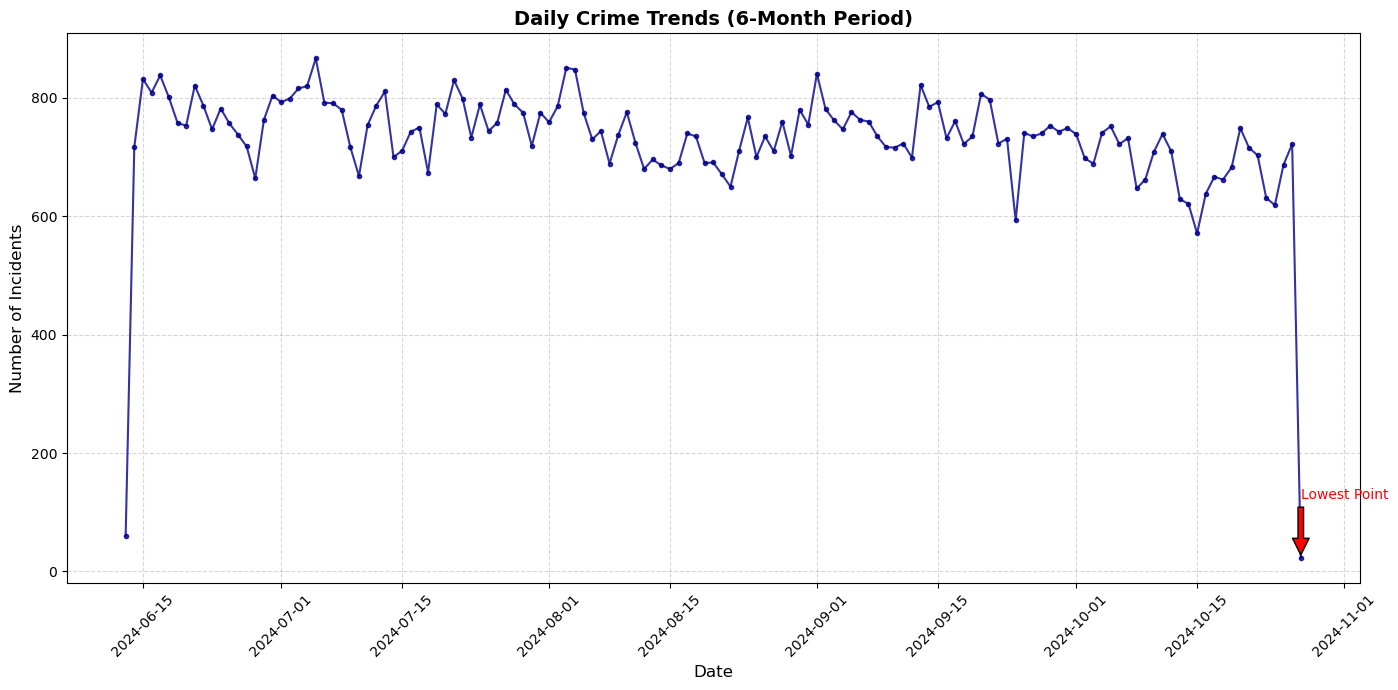

In [29]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Group by the date and count the number of incidents
daily_trends = df.groupby(df['date'].dt.date).size()

# Plot the daily crime trends for the 6-month period
plt.figure(figsize=(14, 7))
plt.plot(daily_trends.index, daily_trends.values, color='darkblue', marker='o', markersize=3, linestyle='-', alpha=0.8)
plt.title('Daily Crime Trends (6-Month Period)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Annotate significant changes, if any
min_value_date = daily_trends.idxmin()
min_value = daily_trends.min()
plt.annotate('Lowest Point', xy=(min_value_date, min_value), xytext=(min_value_date, min_value + 100),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red')

plt.savefig("images/Crime Analysis.png")
plt.show()


<div class="alert alert-block alert-info">
<ul>
<li>
<b>Consitant Crime Rate</b> : The number of incidents remains relatively stable throughout the 6-month period, indicating a steady rate of crime without extreme fluctuations.</li>
<li>
<b>Data Anomaly</b> :  The final data point shows a dramatic decrease, likely suggesting incomplete data rather than an actual decrease in crime incidents.</li>
</ul>
</div>

#### 2. Crime Type Analysis

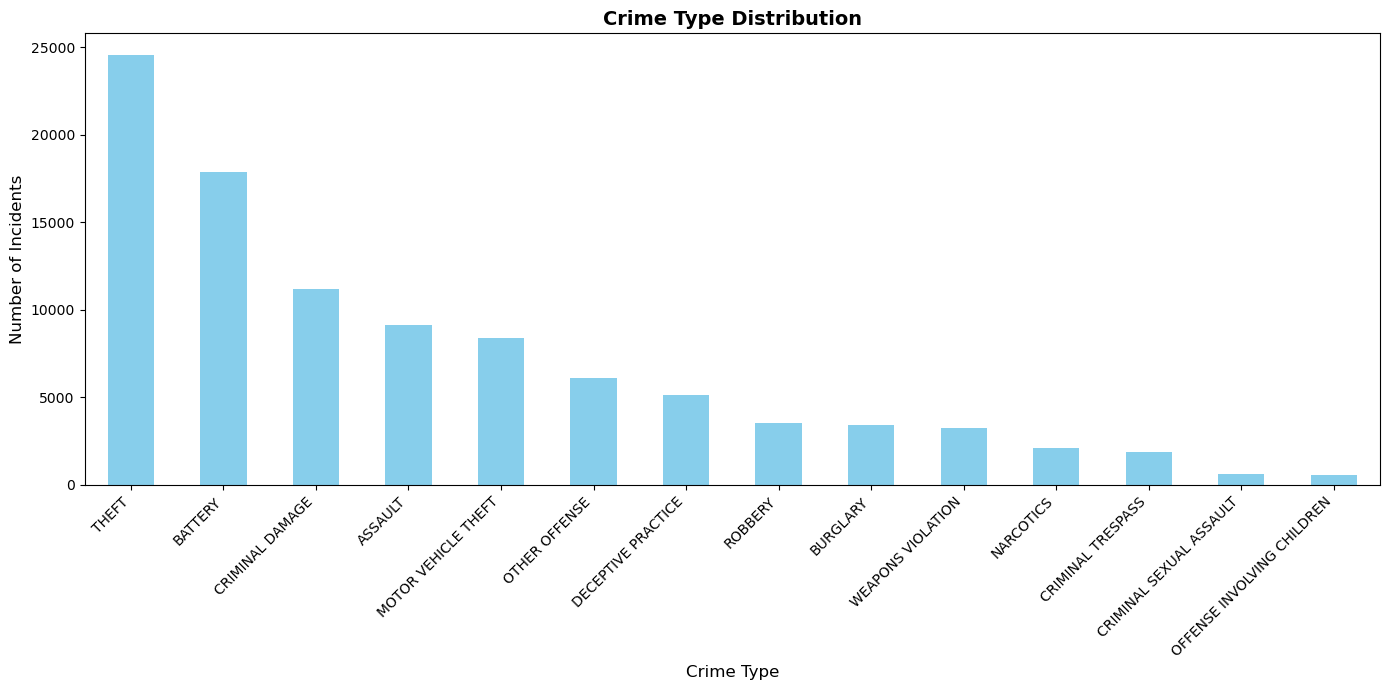

In [30]:
crime_type_counts = df['primary_type'].value_counts().head(14)
plt.figure(figsize=(14, 7))
crime_type_counts.plot(kind='bar', color='skyblue')
plt.title('Crime Type Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Crime Type', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right') 
plt.tight_layout() 
plt.savefig("images/CrimeType.png")
plt.show()

<div class="alert alert-block alert-info">
<ul>
<li>
<b>Theft is the Most Prevalent Crime:</b> :  The highest number of incidents are related to theft, indicating it is a significant issue. Efforts to curb theft could have a substantial impact on overall crime reduction.</li>
<li>
<b>Property Crime vs. Violent Crime: </b> Property-related crimes like theft, damage, and motor vehicle theft appear more frequently than violent crimes. This suggests a focus on property crime prevention strategies may be beneficial.</li>
</ul>
</div>

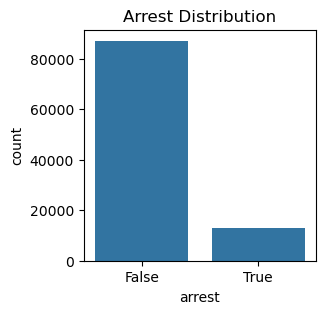

In [31]:
# Arrest analysis
plt.figure(figsize=(3, 3))
sns.countplot(x='arrest', data=df)
plt.title("Arrest Distribution")
plt.show()


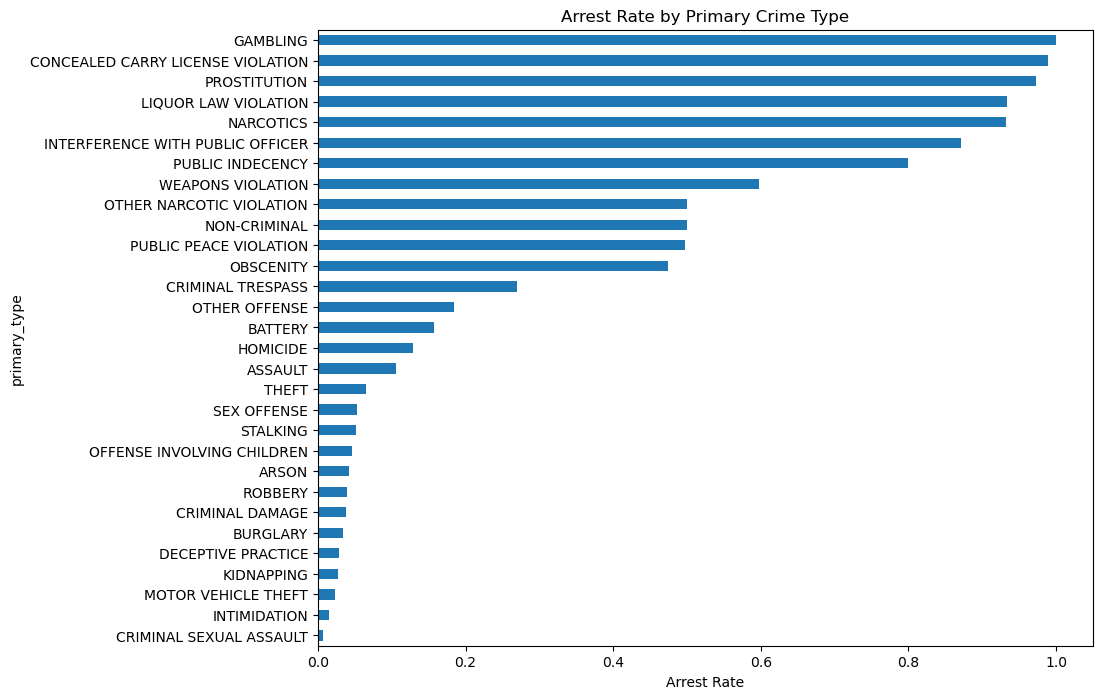

In [32]:
arrest_rate_by_type = df.groupby('primary_type')['arrest'].mean().sort_values()

arrest_rate_by_type.plot(kind='barh', figsize=(10, 8))
plt.title("Arrest Rate by Primary Crime Type")
plt.xlabel("Arrest Rate")
plt.show()


#### 1. Preprocessing & Feature engineering

In [33]:
# Convert 'arrest' to a binary variable (if not already)
df['arrest'] = df['arrest'].astype(int)

# Convert 'date' to datetime and extract time-related features
df['date'] = pd.to_datetime(df['date'])

In [34]:
# Check for missing values
missing=df.isnull().sum()
missing[missing>0]

location_description           304
community_area                   1
x_coordinate                    34
y_coordinate                    34
latitude                        34
longitude                       34
location                        34
:@computed_region_awaf_s7ux    377
dtype: int64

In [35]:
# Check for duplicates
duplicates = df.duplicated().sum()
duplicates

0

In [36]:
df=df.drop(columns=['case_number','id', 'case_number', ':@computed_region_awaf_s7ux', 'location'],axis=1)


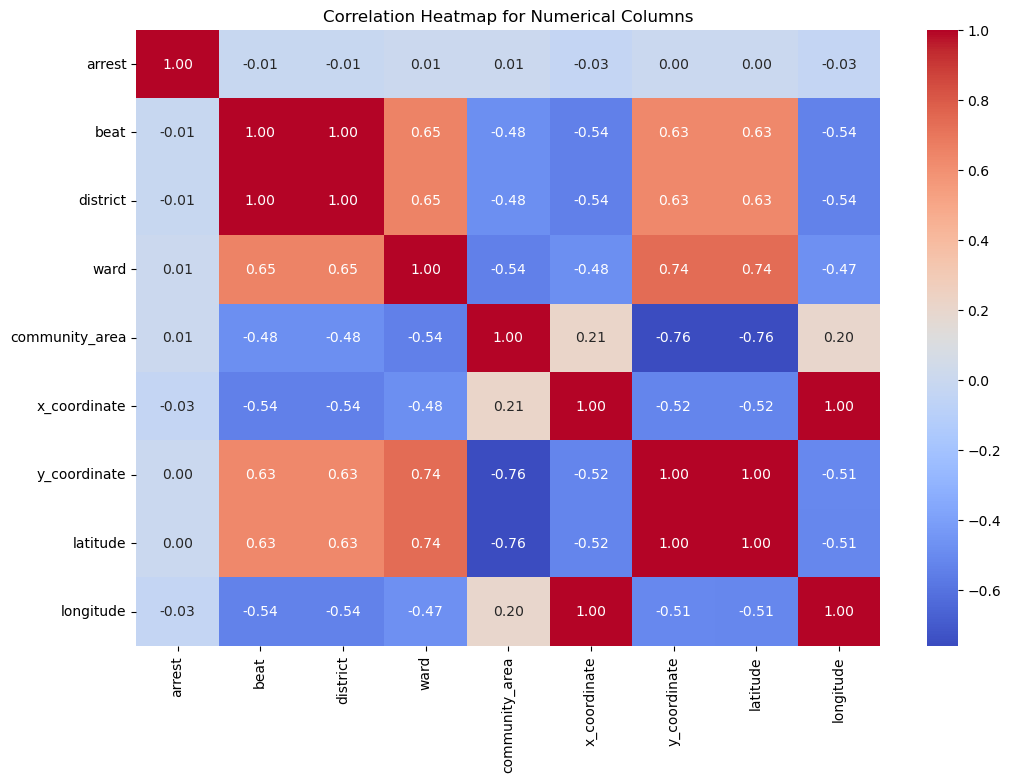

In [72]:
# Correlation Heatmap for Numerical Columns
numerical_columns = ["arrest", "beat", "district", "ward", "community_area", "x_coordinate", "y_coordinate", "latitude", "longitude"]
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap for Numerical Columns")
plt.savefig('heatmap')
plt.show()

<div class="alert alert-block alert-info">
<ul>
<b>Low Correlation with Arrests:</b>

The arrest variable has very low correlation with other numerical features in the dataset (values close to 0), indicating no strong linear relationships.
Features such as beat, district, ward, and geographical coordinates (latitude, longitude, etc.) are not highly predictive of whether an arrest occurs on their own.
</ul>
</div>

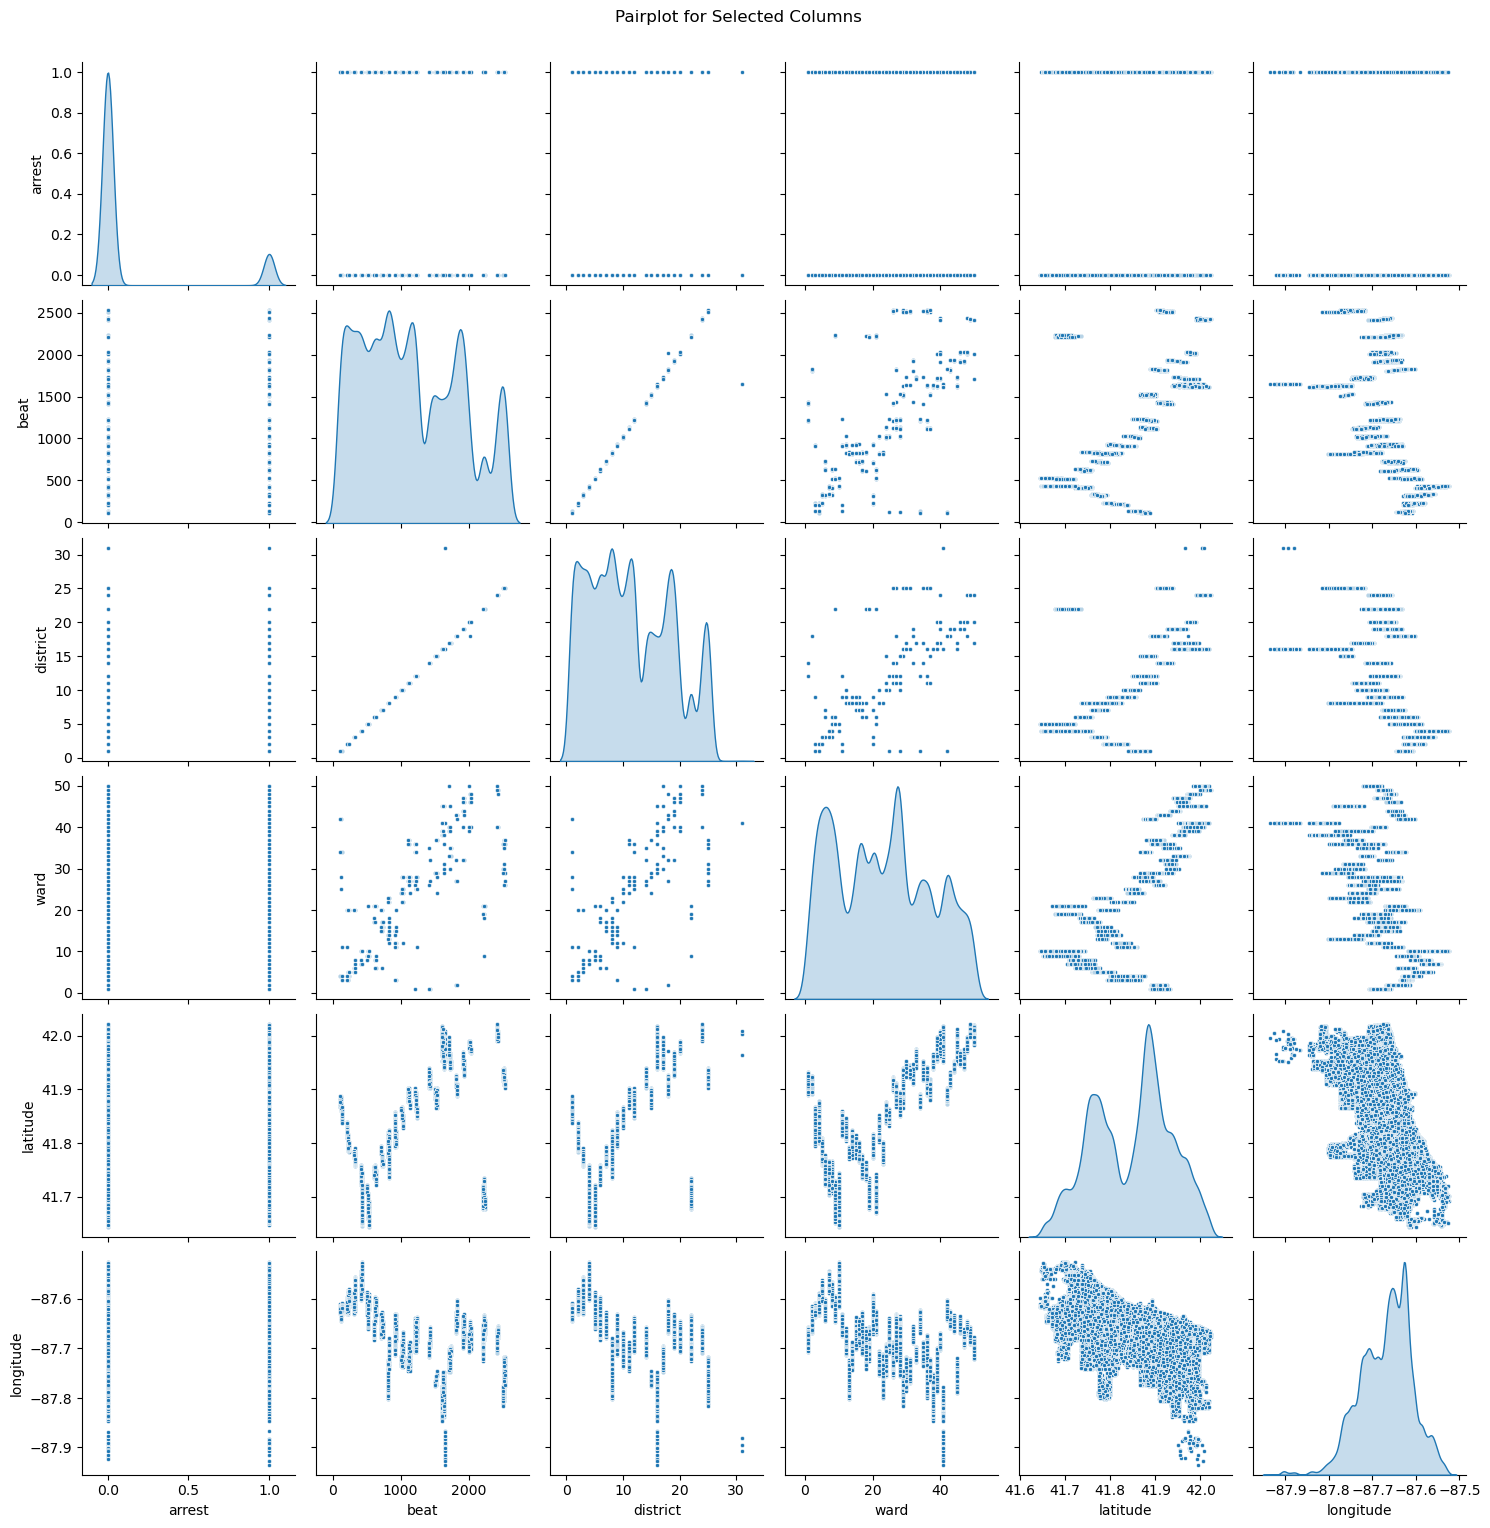

In [49]:
# Pairplot for Selected Columns
selected_columns = ["arrest", "beat", "district", "ward", "latitude", "longitude"]
sns.pairplot(df[selected_columns].dropna(), diag_kind="kde", markers=".")
plt.suptitle("Pairplot for Selected Columns", y=1.02)
plt.show()

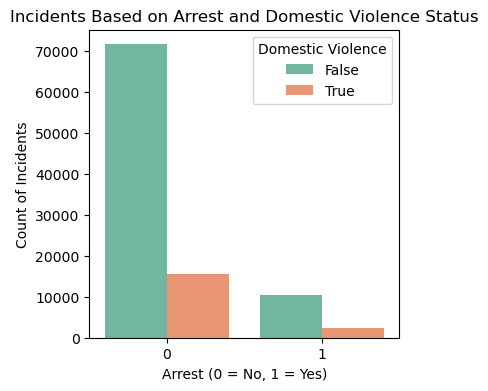

In [81]:
# Analyzing the relationship between Arrest and Domestic columns
arrest_domestic_counts = df.groupby(['arrest', 'domestic']).size().reset_index(name='count')

# Creating a bar plot to visualize the counts of incidents based on arrest and domestic violence status
plt.figure(figsize=(4, 4))
sns.barplot(data=arrest_domestic_counts, x='arrest', y='count', hue='domestic', palette='Set2')
plt.title("Incidents Based on Arrest and Domestic Violence Status")
plt.xlabel("Arrest (0 = No, 1 = Yes)")
plt.ylabel("Count of Incidents")
plt.legend(title="Domestic Violence")
plt.savefig('bar')
plt.show()


<div class="alert alert-block alert-info">
<ul>

Higher Arrest Likelihood: Incidents involving domestic violence are more likely to result in an arrest than those that do not involve domestic violence.
</div>

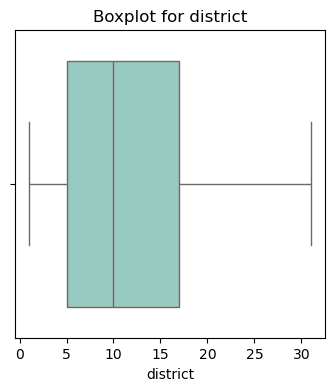

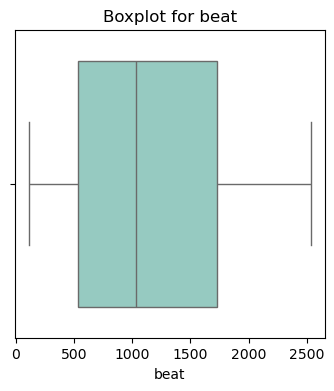

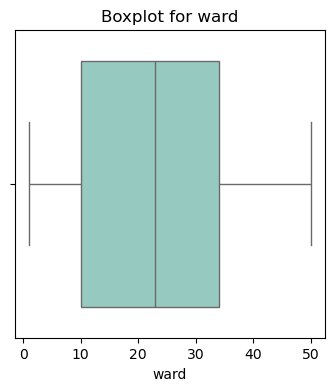

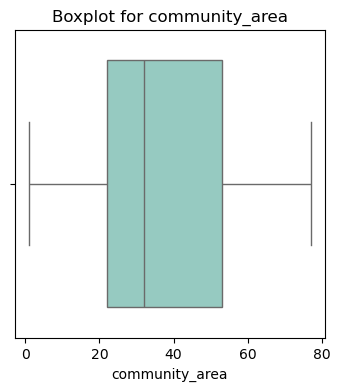

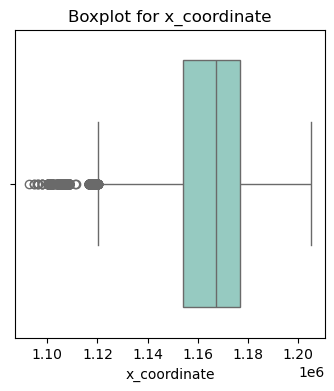

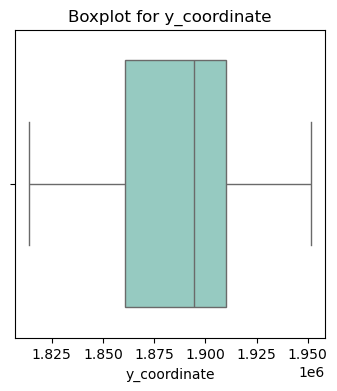

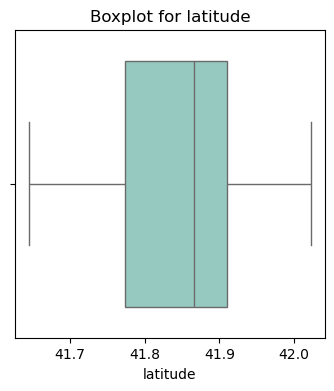

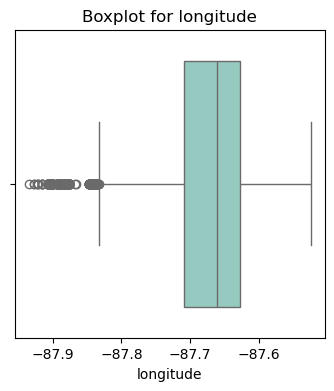

In [74]:
select_col = ['district','beat','ward','community_area','x_coordinate','y_coordinate','latitude','longitude']

# Generate a boxplot for each numeric column
for column in select_col:
    plt.figure(figsize=(4 ,4))  # Set figure size for each boxplot
    sns.boxplot(data=df[select_col], x=column, palette="Set3")
    plt.title(f"Boxplot for {column}")
    plt.savefig('boxplot')
    plt.show()

In [76]:
# X = df.drop(columns=['arrest'])
# y = df['arrest']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [77]:
# numerical_cols = ['x_coordinate', 'y_coordinate', 'latitude', 'longitude', 'year']
# categorical_cols = ['primary_type', 'location_description', 'beat', 'district', 'ward', 'community_area']

# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])


# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ])


In [78]:

# rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                                ('classifier', RandomForestClassifier(random_state=42))])

# rf_pipeline.fit(X_train, y_train)
# rf_preds = rf_pipeline.predict(X_test)
# print("Random Forest Classification Report:")
# print(classification_report(y_test, rf_preds))
# print("Accuracy:", accuracy_score(y_test, rf_preds))


In [79]:

# xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                                 ('classifier', xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))])

# xgb_pipeline.fit(X_train, y_train)
# xgb_preds = xgb_pipeline.predict(X_test)
# print("XGBoost Classification Report:")
# print(classification_report(y_test, xgb_preds))
# print("Accuracy:", accuracy_score(y_test, xgb_preds))


In [75]:
# # 
# # Create an SVM model pipeline
# svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                                ('classifier', SVC(probability=True, random_state=42))])
# svm_pipeline.fit(X_train, y_train)
# svm_preds = svm_pipeline.predict(X_test)
# print("SVM Classification Report:")
# print(classification_report(y_test, svm_preds))
# print("Accuracy:", accuracy_score(y_test, svm_preds))
# # 